# Sistema de Recomendação

Este notebook apresenta algumas implementações de sistema de recomendação utilizando
o dataset Movielens.
Este notebook contém:
- Modelo de Sistema de Recomendação utilizando atributos latentes e produto interno
- Modelo utilizando atributos latentes concatenados e uma rede neural
- Calcula a predição para todos os filmes e usuários que não fizeram suas avaliações
- Visualiza a matriz de avaliações por usuários x filmes com todas as predições
- Análise do significado dos embeddings

Obs: Este notebook foi inspirado em exemplo divulgado pelo curso online disponível em [fast.ai](http://fast.ai)

## Importação da bibliotecas

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from collections import OrderedDict
import numpy as np
import os, sys
import pandas as pd

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable

In [3]:
np.set_printoptions(formatter={'float': '{: 0.1f}'.format})

from lib.pytorch_utils import DeepNetTrainer, test_network

use_gpu = torch.cuda.is_available()
print('GPU available:', use_gpu)

GPU available: False


## Movielens dataset

- [Movielens - Readme](http://files.grouplens.org/datasets/movielens/ml-latest-small-README.html)
- Movielens - Small data set - 100.000 avaliações:[ml-latest-small.zip](http://files.grouplens.org/datasets/movielens/ml-latest-small.zip)

F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4, Article 19 (December 2015).


### Leitura dos Dados - Movielens dataset

Caso a célula a seguir falhar, é necessário executar o notebook:
- [Movielens Dataset](MovieLens_dataset_pytorch.ipynb) que é responsável por ler o dataset original e
prepará-lo para este notebook

Este dataset consiste de:
- 100.004 avaliações de filmes (amostras), feitas por
- 671 usuários, sobre
- 9066 filmes

As amostras estão no array `ratings` organizados da seguinte forma:
- cada linha é uma amostra
- coluna 0 é o iD do usuário
- coluna 1 é o iD do filme
- coluna 2 é a avaliação do usuários entre 0.0 e 5.0

In [4]:
data = np.load('../data/movielens_norm.npz')
ratings     = data['ratings']
movie_names = data['movie_names']
n_samples   = ratings.shape[0]
print('n_samples:',n_samples)
print('ratings:\n', ratings[:5])

n_samples: 100004
ratings:
 [[ 0.0  30.0  2.5]
 [ 0.0  833.0  3.0]
 [ 0.0  859.0  3.0]
 [ 0.0  906.0  2.0]
 [ 0.0  931.0  4.0]]


In [5]:
for i in (ratings[:5,1]).astype(np.int):
    print(movie_names[i])

Dangerous Minds (1995)
Dumbo (1941)
Sleepers (1996)
Escape from New York (1981)
Cinema Paradiso (Nuovo cinema Paradiso) (1989)


In [6]:
h_userId  = np.bincount(ratings[:,0].astype(np.int))
n_users   = h_userId.size
h_movieId = np.bincount(ratings[:,1].astype(np.int))
n_movies  = h_movieId.size
print('n_users:',n_users)
print('n_movies:',n_movies)

n_users: 671
n_movies: 9066


## Divisão dos dados em treinamento e validação

In [7]:
np.random.seed = 42

Faz a divisão com 80% das amostras para treinamento e 20% para validação:

In [8]:
msk = np.random.rand(n_samples) < 0.8
train = ratings[msk]
valid = ratings[~msk]
print('train:',train.shape[0],' amostras:\n',train[:5])
print('valid:',valid.shape[0],' amostras:\n',valid[:5])

train: 80087  amostras:
 [[ 0.0  30.0  2.5]
 [ 0.0  859.0  3.0]
 [ 0.0  906.0  2.0]
 [ 0.0  931.0  4.0]
 [ 0.0  1041.0  2.0]]
valid: 19917  amostras:
 [[ 0.0  833.0  3.0]
 [ 0.0  1017.0  2.0]
 [ 0.0  1140.0  1.0]
 [ 0.0  1815.0  2.0]
 [ 0.0  1962.0  2.5]]


`userId` e `movieId` precisam ser inteiros pois são entradas do *Embedding*:

In [9]:
train_userId  = torch.LongTensor(train[:,0].astype(np.int))
train_movieId = torch.LongTensor(train[:,1].astype(np.int))
train_ratings = torch.FloatTensor(train[:,2:3]) # importante que fique bidimensional
valid_userId  = torch.LongTensor(valid[:,0].astype(np.int))
valid_movieId = torch.LongTensor(valid[:,1].astype(np.int))
valid_ratings = torch.FloatTensor(valid[:,2:3]) # importante que fique bidimensional

## Definição da classe MLDataset

In [16]:
from torch.utils.data import Dataset
class MLDataset(Dataset):
    
    def __init__(self, data_user, data_movie, target):
        assert data_user.size(0)  == target.size(0) and \
               data_movie.size(0) == target.size(0)
        
        self.data   = torch.transpose(torch.stack( (data_user, data_movie) ),0,1)
        self.target = target
    
    def __len__(self):
        return self.target.size(0)
    
    def __getitem__(self, i):
        return (self.data[i], self.target[i])

### Criação dos objetos datasets e dataloaders

In [17]:
datasets = {
    'train': MLDataset(train_userId, train_movieId, train_ratings),
    'val'  : MLDataset(valid_userId, valid_movieId, valid_ratings)
    }

dataloaders = {
    'train': torch.utils.data.DataLoader(datasets['train'], batch_size=64, shuffle=True, num_workers=0),
    'val'  : torch.utils.data.DataLoader(datasets['val'], batch_size=64, shuffle=True, num_workers=0)
    }

dataset_sizes = {
    'train': len(datasets['train']),
    'val'  : len(datasets['val'])
    }

print(dataset_sizes)

{'train': 80087, 'val': 19917}


### Testando os datasets

In [19]:
x, y = datasets['train'][3:5]
print(x)
print(y)


    0   931
    0  1041
[torch.LongTensor of size 2x2]


 4
 2
[torch.FloatTensor of size 2x1]



### Testando os dataloaders

In [20]:
batch_size = 64
print( len(dataloaders['val']) * batch_size ) # verificando mini-batches
for k,data in enumerate(dataloaders['val']):
    print(k, len(data[0]), len(data[1]))
    if k > 1: break

19968
0 64 64
1 64 64
2 64 64


## Primeira solução - usando produto interno: Dot

<img src='../figures/Recomendacao_dot.png', width=600ptx></img>

O primeiro modelo é o produto interno entre os atributos latentes dos usuários e dos filmes.
Este produto interno é implementado pelo produto elemento por elemento das matrizes
de atributos dos usuários e dos filmes e posteriormente somado, resultado um valor escalar por amostra:

In [21]:
class DotNet(nn.Module):
    def __init__(self, n_users, n_movies, n_attributes):
        """
        No construtor, criamos as duas embeddings, uma para os usuários e 
        outra para os filmes.
        """
        super(DotNet, self).__init__()
        self.user_emb  = nn.Embedding(n_users, n_attributes)
        nn.init.xavier_uniform(self.user_emb.weight)
        self.movie_emb = nn.Embedding(n_movies, n_attributes)
        nn.init.xavier_uniform(self.movie_emb.weight)

    def forward(self, x):
        """
        x: (user_id, movie_id)
        """
        user_id  = x[:,0]
        movie_id = x[:,1]
        user_attr  = self.user_emb(user_id)
        movie_attr = self.movie_emb(movie_id)
        y_pred = (user_attr * movie_attr).sum(1)
        return y_pred


### Instanciando a rede

In [22]:
n_factors = 50
model_dot = DotNet(n_users, n_movies, n_factors)
if use_gpu:
    model_dot.cuda()
model_dot

DotNet (
  (user_emb): Embedding(671, 50)
  (movie_emb): Embedding(9066, 50)
)

### Testando o predict e o loss da rede com poucos dados e sem treinar

In [24]:
criterion = nn.MSELoss(size_average=True)
data_um = torch.transpose(torch.stack( (train_userId[0:3],train_movieId[0:3]) ),1,0)
print(data_um)
if use_gpu:
    data_um = data_um.cuda()
    train_ratings = train_ratings.cuda()
y_pred = model_dot(Variable(data_um))
print(y_pred)
loss = criterion(y_pred, Variable(train_ratings[0:3]))
print(loss)


   0   30
   0  859
   0  906
[torch.LongTensor of size 3x2]

Variable containing:
1.00000e-03 *
 -1.7627
  0.7512
 -1.7788
[torch.FloatTensor of size 3]

Variable containing:
 6.4205
[torch.FloatTensor of size 1]



### Testando o predict e loss com dataset

In [25]:
x,y = datasets['train'][3:4]
if use_gpu:
    x = x.cuda()
    y = y.cuda()
print(x)
print(y)
y_pred = model_dot(Variable(x))
print(y_pred)
loss = criterion(y_pred, Variable(y))
print(loss)


   0  931
[torch.LongTensor of size 1x2]


 4
[torch.FloatTensor of size 1x1]

Variable containing:
1.00000e-03 *
 -1.0458
[torch.FloatTensor of size 1]

Variable containing:
 16.0084
[torch.FloatTensor of size 1]



### Testando o predict e o dataset

### Treinando a rede

Verificando se um pequeno conjunto de dados consegue treinar a rede

In [26]:
batch_size = 64
optimizer = torch.optim.Adam(model_dot.parameters())
for t in range(5):
    # Forward pass: Compute predicted y by passing x to the model
    data_um = torch.transpose(torch.stack( (train_userId[0:batch_size],
                                            train_movieId[0:batch_size]) ),0,1)

    if use_gpu:
        data_um = data_um.cuda()
        train_ratings = train_ratings.cuda()
    y_pred = model_dot((Variable(data_um)))

    # Compute and print loss
    loss = criterion(y_pred, Variable(train_ratings[:batch_size]))
    print(t, loss.data[0])

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0 11.775581359863281
1 11.760848045349121
2 11.746047973632812
3 11.731011390686035
4 11.715614318847656


In [27]:
a = torch.pow(y_pred.data - train_ratings[:batch_size],2).mean()
a = torch.pow(y_pred.data ,2).mean()
a

0.0001187465004410904

In [38]:
trainer = DeepNetTrainer(
    file_basename ='../../models/Recomendacao_dot', 
    model         = model_dot, 
    criterion     = nn.MSELoss(), 
    optimizer     = torch.optim.Adam(model_dot.parameters()), 
    reset         = False)

In [40]:
trainer.fit(n_epochs=8, 
            train_data = dataloaders['train'], 
            valid_data = dataloaders['val'])

Starting training for 8 epochs

  1:   1.3s   T: 0.88615   V: 1.29240 best
  2:   1.3s   T: 0.72529   V: 1.25353 best
  3:   1.3s   T: 0.62582   V: 1.24479 best
  4:   1.2s   T: 0.55245   V: 1.24161 best
  5:   1.3s   T: 0.49302   V: 1.24422 
  6:   1.3s   T: 0.44072   V: 1.25982 
  7:   1.3s   T: 0.39497   V: 1.26300 
  8:   1.3s   T: 0.34990   V: 1.27171 

Model from epoch 4 saved as "../../models/Recomendacao_dot.*", loss = 1.24161


### Avaliando a rede

In [41]:
y_pred = trainer.predict(dataloaders['val'])

predict: 313/313 ok


In [42]:
a = ((y_pred.numpy() - valid_ratings.numpy())**2).mean()
a

2.2393303

In [43]:
w_dict = torch.load('../../models/Recomendacao_dot.model')

In [44]:
w_dict = model_dot.state_dict()

-2.200576066970825 2.259248733520508 -0.14902162551879883 0.45777004957199097
-0.7715634703636169 0.8372213244438171 -0.046350229531526566 0.15234851837158203


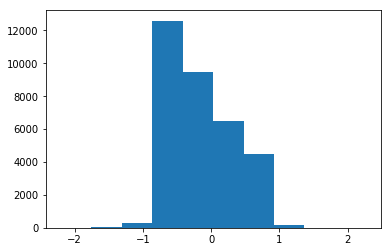

In [46]:
w_user = w_dict['user_emb.weight']
w_movie= w_dict['movie_emb.weight']
print(w_user.min(), w_user.max(), w_user.mean(),w_user.std())
print(w_movie.min(), w_movie.max(), w_movie.mean(),w_movie.std())
plt.hist(w_user.cpu().numpy().ravel());

In [47]:
trainer.print_losses(0)

  0:   0.0s   T: 0.34990   V: 1.27171 best


Os bons modelos [best benchmarks](http://www.librec.net/example.html) são próximos de 0.9, há necessidade de melhorias.

### Predição de usuário e filme

Para calcular qualquer predição de qualquer usuário e qualquer filme, usa-se o `predict` do modelo treinado:

In [48]:
trainer.predict([np.array([3]), np.array([6])])

ValueError: not enough values to unpack (expected 2, got 1)

##  Usado Rede Neural

<img src='../figures/Recomendacao_NN.png', width=600ptx></img>

Uma solução usando rede neural é concatenar a saída dos embeddings e em seguida colocar uma camada densa
antes da última camada de um neurônio. No exemplo a seguir foi utilizado uma camada de 70 neurônios.

In [49]:
class RecommendNet(nn.Module):
    def __init__(self, n_users, n_movies, n_attributes):
        """
        No construtor, criamos as duas embeddings, uma para os usuários e 
        outra para os filmes e duas densas.
        """
        super(RecommendNet, self).__init__()
        self.user_emb  = nn.Embedding(n_users, n_attributes)
        nn.init.xavier_uniform(self.user_emb.weight)
        self.movie_emb = nn.Embedding(n_movies, n_attributes)
        nn.init.xavier_uniform(self.movie_emb.weight)
        self.dense1 = nn.Linear(2*n_attributes, 70)
        nn.init.xavier_uniform(self.dense1.weight, gain=nn.init.calculate_gain('relu'))
        self.dense2 = nn.Linear(70,1)
        nn.init.xavier_uniform(self.dense2.weight, gain=nn.init.calculate_gain('relu'))

    def forward(self, x):
        """
        x: (user_id, movie_id)
        """
        user_id  = x[:,0]
        movie_id = x[:,1]
        user_attr  = self.user_emb(user_id)
        movie_attr = self.movie_emb(movie_id)
        x1 = torch.cat((user_attr,movie_attr),dim=1)
        x2 = nn.functional.dropout(x1,0.3)
        x3 = nn.functional.relu(self.dense1(x2))
        x4 = nn.functional.dropout(x3,0.75)
        y_pred = self.dense2(x4)
        return y_pred
    
    # Método auxiliar para depuração, para mostrar a saída de cada parte da rede
    def modules_output(self, x):
        output = OrderedDict()        

        user_id  = x[:,0]
        movie_id = x[:,1]
        user_attr  = self.user_emb(user_id)
        movie_attr = self.movie_emb(movie_id)
        x0 = torch.cat((user_attr,movie_attr),dim=1)
        output['x0'] = x0
        x1 = x0
        output['x1'] = x1
        x2 = nn.functional.dropout(x1,0.3)
        output['x2'] = x2
        x3 = nn.functional.relu(self.dense1(x2))
        output['x3'] = x3
        x4 = nn.functional.dropout(x3,0.75)
        output['x4'] = x4
        y_pred = self.dense2(x4)
        output['y_pred'] = y_pred
        
        return output

In [50]:
model_net = RecommendNet(n_users, n_movies, n_factors)
if use_gpu:
    model_net = model_net.cuda()
model_net

RecommendNet (
  (user_emb): Embedding(671, 50)
  (movie_emb): Embedding(9066, 50)
  (dense1): Linear (100 -> 70)
  (dense2): Linear (70 -> 1)
)

### Testando o predict da rede com uma amostra

In [52]:
data_um = torch.transpose(torch.stack( (train_userId[0:1],train_movieId[0:1]) ),1,0)
if use_gpu:
    data_um = data_um.cuda()
    train_ratings = train_ratings.cuda()
print(data_um)
y_pred = model_net(Variable(data_um))
print(y_pred, train_ratings[0:1])
loss = criterion(y_pred, Variable(train_ratings[0:1]))
print(loss)


   0  906
[torch.cuda.LongTensor of size 1x2 (GPU 0)]

Variable containing:
1.00000e-02 *
 -4.5913
[torch.cuda.FloatTensor of size 1x1 (GPU 0)]
 
 2
[torch.cuda.FloatTensor of size 1x1 (GPU 0)]

Variable containing:
 4.1858
[torch.cuda.FloatTensor of size 1 (GPU 0)]



In [55]:
output = model_net.modules_output(Variable(data_um))
for layer in ['x0','x1','x2','x3','x4','y_pred']:
    print(layer,output[layer].cpu().data.numpy()[0,:14],output[layer].cpu().data.numpy().shape)


x0 [ 0.0  0.0  0.0  0.0 -0.1  0.0  0.1 -0.0 -0.1  0.0 -0.0  0.1 -0.0 -0.0] (1, 100)
x1 [ 0.0  0.0  0.0  0.0 -0.1  0.0  0.1 -0.0 -0.1  0.0 -0.0  0.1 -0.0 -0.0] (1, 100)
x2 [ 0.0  0.0  0.0  0.0 -0.1  0.0  0.1 -0.0 -0.1  0.0 -0.0  0.1 -0.0 -0.0] (1, 100)
x3 [ 0.0  0.0  0.1  0.1  0.0  0.1  0.1  0.1  0.0  0.0  0.0  0.0  0.0  0.0] (1, 70)
x4 [ 0.0  0.0  0.1  0.1  0.0  0.1  0.1  0.1  0.0  0.0  0.0  0.0  0.0  0.0] (1, 70)
y_pred [-0.0] (1, 1)


In [56]:
trainer_net = DeepNetTrainer(
    file_basename= '../../models/Recomendacao_net', 
    model=         model_net, 
    criterion=     nn.MSELoss(), 
    optimizer=     torch.optim.Adam(model_net.parameters()), 
    reset=         True)

In [57]:
trainer_net.fit(n_epochs=20, 
            train_data = dataloaders['train'], 
            valid_data = dataloaders['val'])

Starting training for 20 epochs

  1:   1.8s   T: 1.46797   V: 0.81235 best
  2:   1.8s   T: 0.75784   V: 0.79810 best
  3:   1.8s   T: 0.70405   V: 0.77714 best
  4:   1.8s   T: 0.65828   V: 0.78433 
  5:   1.8s   T: 0.60871   V: 0.79349 
  6:   1.8s   T: 0.55362   V: 0.81750 
  7:   1.8s   T: 0.49587   V: 0.84972 
  8:   1.8s   T: 0.44402   V: 0.86367 
  9:   1.8s   T: 0.39716   V: 0.89786 
 10:   1.8s   T: 0.35818   V: 0.91380 
 11:   1.8s   T: 0.32328   V: 0.92670 
 12:   1.8s   T: 0.29466   V: 0.95669 
Interrupted!!

Model from epoch 3 saved as "../../models/Recomendacao_net.*", loss = 0.77714


### Avaliando a rede

In [59]:
test_network(trainer_net.model, TensorDataset(datasets['train']) )

TypeError: __init__() missing 1 required positional argument: 'target_tensor'

Com esta rede, a perda já é bem melhor, comparável com os melhores sistemas de recomendação.

## Matriz de recomendações, por usuário e por filme

O sistema de recomendação pode ser visualizado por uma matriz onde as linhas sejam os
IDs dos usuários e as colunas sejam os IDs dos títulos dos filmes. Colocamos como -1
os elementos em que não existem avaliações. Esta matriz é bastante esparsa, pois existem
normalmente poucas avaliações feitas.

In [174]:
grid_ratings = -1. * np.ones((n_users,n_movies))
uId = (ratings[:,0]).astype(np.int)
mId = (ratings[:,1]).astype(np.int)
grid_ratings[uId,mId] = ratings[:,2] # Criação da matriz
print(grid_ratings.shape)

(671, 9066)


### Visualização da matriz de recomendações, original

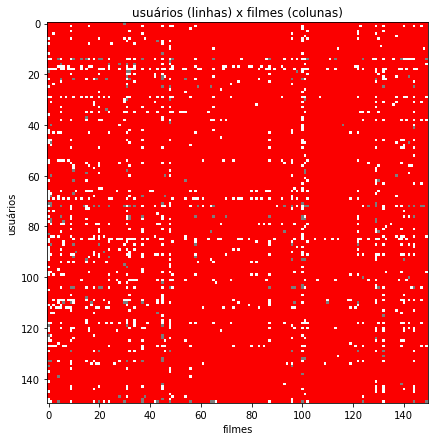

In [175]:
show_ratings = np.zeros((n_users,n_movies,3))
show_ratings[:,:,0] = np.where(grid_ratings == -1., 5, grid_ratings)
show_ratings[:,:,1] = np.where(grid_ratings == -1., 0., grid_ratings)
show_ratings[:,:,2] = np.where(grid_ratings == -1., 0., grid_ratings)


import matplotlib.pyplot as plt
plt.figure(figsize=(7,7))
plt.title('usuários (linhas) x filmes (colunas)')
plt.imshow(show_ratings[:150,:150,:])
plt.xlabel('filmes')
plt.ylabel('usuários')
plt.show()

## Predições para todos os usuários e filmes

In [ ]:
n2p_user,n2p_movie = np.nonzero(grid_ratings==-1)
recommend = model_nn.predict([n2p_user, n2p_movie])

### Montagem da matriz de recomendação "cheia"

In [ ]:
gg = grid_ratings.copy()
gg[n2p_user,n2p_movie] = recommend[:,0]

plt.figure(figsize=(8,8))
plt.title('usuários (linhas) x filmes (colunas)')
plt.xlabel('usuarios')
plt.ylabel('filmes')
plt.imshow(gg[:150,:150],cmap='gray')
plt.show()

### Visualização de uma parte da matriz

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(show_ratings[:150,:150,:])

### Visualização da parte de usuários mais ativos e filmes mais populares

In [ ]:
io_popular_movies = np.argsort(h_movieId)[::-1]
io_top_users = np.argsort(h_userId)[::-1].astype(np.int)
gg_ord = gg[np.ix_(io_top_users,io_popular_movies)]
plt.figure(figsize=(7,7))
plt.title('usuários (linhas) x filmes (colunas)')
plt.imshow(gg_ord[:150,:150],cmap='gray')
plt.show()

### Visualização dos usuários menos ativos e filmes menos avaliados

In [ ]:
plt.figure(figsize=(7,7))
plt.title('usuários (linhas) x filmes (colunas)')
plt.imshow(gg_ord[-150:,-150:],cmap='gray')
plt.show()

## Analise dos embeddings dos filmes

A análise a seguir será feita apenas com os 2000 filmes mais populares:

In [ ]:
topMovies = io_popular_movies[:2000]

### Extração dos atributos latentes (embeddings) dos 2000 fimes mais populares

Para obter os atributos latentes dos 2000 filmes mais populares, primeiro criamos uma
nova rede, denominada `get_movie_emb`, a partir da rede `Model`, com a entrada apenas o ID dos filmes e
a saída `m`, após o embedding. Aplicamos a predição desta rede nos `topMovies`:

In [ ]:
get_movie_emb = Model(movie_in, m)
m_emb = get_movie_emb.predict([topMovies])
movie_emb = np.squeeze(m_emb) # elimina dimensões 1
print(m_emb.shape)
movie_emb.shape

Como o embedding de cada filme tem dimensão 50, é muito difícil conseguir analisá-lo desta forma.
Uma forma muito usual é reduzir esta dimensionalidade utilizando uma técnica denominada PCA -
Principal Component Analysis: [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/).
Iremos reduzir a dimensão dos embeddings de 50 para 3. 

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

#### Filmes com alto valor na primeira dimensão do PCA

In [ ]:
fac0 = movie_pca[0]
isort = np.argsort(fac0)[::-1]

for ii in isort[:15]:
    print(fac0[ii],movie_names[ii])

#### Filmes com baixo valor na primeira dimensão do PCA

In [ ]:
for ii in isort[-15:]:
    print(fac0[ii],movie_names[ii])

### Análise da segunda dimensão do PCA

In [ ]:
fac1 = movie_pca[1]
isort = np.argsort(fac1)[::-1]

#### Mais bem avaliados na segunda dimensão

In [ ]:
for ii in isort[:15]:
    print(fac1[ii],movie_names[ii])

#### Piores avaliados na segunda dimensão

In [ ]:
for ii in isort[-15:]:
    print(fac1[ii],movie_names[ii])

### Análise da terceira dimensão do PCA

In [ ]:
fac2 = movie_pca[2]
isort = np.argsort(fac2)[::-1]

#### Mais bem avaliados na terceira dimensão do PCA

In [ ]:
for ii in isort[:15]:
    print(fac2[ii],movie_names[ii])

#### Piores avaliados na terceira dimensão do PCA

In [ ]:
for ii in isort[-15:]:
    print(fac2[ii],movie_names[ii])

### Visualizando duas dimensões do PCA

In [ ]:
start=50; end=100
X = fac0[start:end]
Y = fac2[start:end]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[start:end], X, Y):
    plt.text(x,y,movie_names[i], color=np.random.rand(3)*0.7, fontsize=14)
plt.show()

## Exercícios

1. Inclua um novo usuário, sem nenhuma avaliação. Treine a rede e verifique
   se após a rede treinada, se haverá alguma avaliação.
2. Com o novo usuário, faça uma única avaliação e verifique quais os 10 filmes
   mais recomendados para ele.

## Aprendizados com este notebook